In [ ]:
from datetime import datetime
from datetime import timedelta
from iexfinance.stocks import get_historical_intraday, Stock
from iexfinance import refdata, utils
import numpy as np
import pandas as pd
import time

import pylab as pl

# stocks = ["AAPl","GOOG",""]
# NUM_DAYS = 5


TOKEN = "pk_aad994f575a04ea6aad1bdd9128294e8"
TODAY = pd.datetime.today() + timedelta(-1)


def getSymbols(token):
    listings = pd.DataFrame.from_dict(refdata.get_symbols(token=token, format='pandas'))
    symbols = list(listings.loc[(listings['isEnabled']==True) & 
                 (listings['exchange'] == "NYS") | (listings['exchange'] == "NAS")].symbol)
    return symbols

def generateList(stocks,begin_date,end_date,token):
    dates = pd.date_range(begin_date, 
                          end_date).to_list()
    fullList = []
    for stock in stocks:
        print(stock)
        templist = []
        for date in dates:
            try:
                templist.append(get_historical_intraday(stock, date,token=token, 
                                                        output_format='pandas')['close'])
            except(KeyError):
                pass
            except(utils.exceptions.IEXQueryError):
                while True:
                    try:
                        templist.append(get_historical_intraday(stock, date,token=token, 
                                                        output_format='pandas')['close'])
                    except(utils.exceptions.IEXQueryError):
                        time.sleep(5)
                        continue
                    break
        fullList.append(templist)
    print(fullList)
    
    for index, dataframes in enumerate(fullList):
        try:
            fullList[index] = pd.concat(dataframes)
        except:
            pass
    combined_df = pd.concat(fullList,axis=1,keys=stocks)
    return combined_df.dropna(axis=1, how='all')

def format_df(dataframe):
    dataframe = pd.DataFrame.interpolate(dataframe, 
                                         method='polynomial',order=1)\
        .fillna(method='ffill').fillna(method='bfill')
    # dataframe = dataframe / dataframe.iloc[-1]
    dataframe = dataframe.pct_change()
    return dataframe
    
def zeroed_df(dataframe):
    dataframe = pd.DataFrame.interpolate(dataframe, 
                                         method='polynomial',order=1).\
        fillna(method='ffill').fillna(method='bfill')
    dataframe = dataframe / dataframe.iloc[-1] / np.std(dataframe)
    # dataframe = dataframe.pct_change()
    return dataframe.apply(np.log)

def saveDfTempFile(dataframe,file_name,home_dir=""):
    dataframe.to_pickle(home_dir + "./" + file_name + ".pkl")
    return home_dir + file_name + ".pkl"

symbol_list = getSymbols(TOKEN)

df = generateList(symbol_list,TODAY,TODAY,TOKEN)

zeroed = zeroed_df(df)
formatted_df = format_df(df)

local_p = saveDfTempFile(df,"Price")
local_p_r = saveDfTempFile(formatted_df,"Price_Return")
local_p_n = saveDfTempFile(zeroed,"Price_Normalized")

IEXQueryError: An error occurred while making the query.

In [11]:
test = Stock("AAPL",output_format='pandas',token=TOKEN).get_historical_prices()
test.head

IEXQueryError: An error occurred while making the query.

In [25]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
    
# initial creation of root folder Intraday
# #Create folder
# folder_metadata = {'title' : 'Intraday', 'mimeType' : 'application/vnd.google-apps.folder'}
# folder = drive.CreateFile(folder_metadata)
# folder.Upload()
# 
# #Get folder info and print to screen
# foldertitle = folder['title']
# folderid = folder['id']
# print('title: %s, id: %s' % (foldertitle, folderid))

#Upload new folder to folder
ROOT_ID = "1Tr3q-JKaZ3zC3iKJT9CYp5lqWs6C1PPj"

def initializeG():
    gauth = GoogleAuth()
    gauth.LocalWebserverAuth()
    
    drive_client = GoogleDrive(gauth)
    return drive_client

def createNewDir(parent_id, title, drive_client):
    file = drive_client.CreateFile({"parents": [{"kind": "drive#fileLink", "id": parent_id}],
                             'mimeType' : 'application/vnd.google-apps.folder',
                             'title':title})
    # file.SetContentFile('testpic.jpg')
    file.Upload()
    return file['id']

# Parent folder, title of file, file object
def savefileInDir(parent_id,file_upload,drive_client):    
    file = drive_client.CreateFile({"parents": [{"kind": "drive#fileLink", "id": parent_id}]})
    file.SetContentFile(file_upload)
    file.Upload()
    return file['id']

In [32]:
# client = initializeG()
today_id = createNewDir(ROOT_ID, TODAY.strftime('%Y-%m-%d'), client)

savefileInDir(today_id, local_p, client)
savefileInDir(today_id, local_p_r, client)
savefileInDir(today_id, local_p_n, client)



'11ETzlZIpRvSpvM-GxC3ZvsuE2pIUFUU2'

In [ ]:
import numpy as np
from scipy.spatial import distance
from itertools import combinations

from fastdtw import fastdtw

pairs = list(combinations(stocks,2))

for (stock1, stock2) in pairs:
    distance, path = fastdtw(zeroed[stock1][1:], 
                             formatted_df[stock2][1:], dist=distance.euclidean)
    print(distance)
    # print(stock1,stock2)

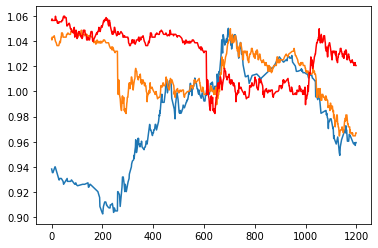

In [837]:
# test = pd.DataFrame.interpolate(test,method='polynomial',order=2)
plt.plot((zeroed["HEXO"][1300:2500]/zeroed["HEXO"][1850]).reset_index(drop=True))
plt.plot((zeroed["ACB"][1300:2500]/zeroed["ACB"][1800]).reset_index(drop=True))
plt.plot((zeroed["ACB"][950:2150]/zeroed["ACB"][1800]).reset_index(drop=True),c="red")
#if lagged corelation is steady and autocorrelation is high, then trade
# LONG
#1) if corr high AND both stocks going down at the moment, CORR effect > LAG effect, DONT BUY
#2) if lag is stable (don't trade while lengths is moving or just finished moving) 
#   and is expected to last longer than lag time, then continue
#3) Keep longing/shorting while lag is stable and lagged correlation is high
#4) STOP trading immediately when lag becomes unstable/lag correlation stops/regular correlations shoots up/there is a price shock

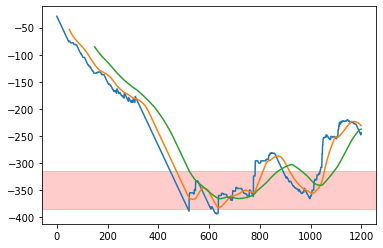

In [ ]:
import matplotlib.pyplot as plt

# lengths = [a-b for a,b in path]
full = pd.DataFrame(path)
full.drop_duplicates(subset=1,keep='last',inplace=True)
lengths = list(full[0]-full[1])

plt.plot(lengths[950:2150])
plt.plot(pd.Series(lengths[950:2150]).rolling(window=50).mean().values)
plt.plot(pd.Series(lengths[950:2150]).rolling(window=100).mean().values)
plt.axhspan(-350*0.9, -350*1.1, color='red', alpha=0.2)
# check if value stays within range longer than the lag value

In [830]:
np.median(lengths)

-2.0

In [819]:
pairs

[('HEXO', 'ACB')]

In [ ]:
import pandas as pd

token = "pk_d5ea01d9598a456098e2e7a7f72f155c"

from iexfinance import refdata

def getSymbols():
    listings = pd.DataFrame.from_dict(refdata.get_symbols(token=token, format='pandas'))
    symbols = list(listings.loc[(listings['isEnabled']==True) & 
                 (listings['exchange'] == "NYS") | (listings['exchange'] == "NAS")].symbol)
    return symbols


In [54]:
listings = pd.DataFrame.from_dict(refdata.get_symbols(token=token, format='pandas'))
symbols = list(listings.loc[(listings['isEnabled']==True) & 
             (listings['exchange'] == "NYS") | (listings['exchange'] == "NAS")].symbol)
symbols = [a for a in symbols if a.isalpha()]

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=485513866766-tfj8ae7vdjs9ptfpl332s93a4hhrl7oc.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code



Authentication successful.


In [10]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Investments - Stock Pitch, id: 1ZkJMfvoWKbgbRI8jQuhl8k-xinEc6XNHcBCaXooDa_w
title: Investments - Stock Pitch - Column chart 4, id: 15NeXWkkZ7lm9y2ey-E8g0VAPsBA9Q-sj4gVtdTkmHh8
title: Investments - Stock Pitch - Pie chart 2, id: 1vF7IEOX8ztzV-MuILB6RrH_28NaWP3HZiJ4laJPa2bM
title: Investments - Stock Pitch - Column chart 1, id: 17B5q5vgVlU1nLK5G8i7f7m2oD-vcGNt3M1K0Bk9g3Io
title: Investments - Stock Pitch - Column chart 3, id: 11ziiSWm7xWgGXOqO95rbjnhWJpSo2zERkzc_gEbwCYI
title: Untitled document, id: 1pmUesPNnZZl3h3oIbk6gegbJyTZ6p8wVsh_KooRDDAE
title: Benjamin Kang Resume 6-11-19.pdf, id: 1YJdn7iea01nVpdmg8WjQHy58sIv6_3lH
title: course list for graduation.docx, id: 1YAaNf-C32LDn2NIo0msyjuHDoyxbgA6e
title: Major Requirements.xlsx, id: 1NXgN-bJbSYTZ7Z-nxNZB8n-tO0kkozu0
title: ~$Major Requirements.xlsx, id: 1de1JfoRstrk0LqtCRmZTsbKMibALg-Gk
title: course list for graduation.docx, id: 1BZcsoaIxkpHm-sjNWobjbht6aVKmznU5
title: ~$urse list for graduation.docx, id: 16esYbJwULwR6aLIab7qz0cp

In [16]:
createNewDir("newFolder")

'14ctOFqbIpCSLfU2plrnnnjm7FY7auMvX'